# Семинар 8

### Методы обработки текстов. Зачем?

Примеры задач автоматической обработки текстов:

- классификация текстов

    - анализ тональности
    - фильтрация спама
    - по теме или жанру

- машинный перевод

- распознавание речи

- извлечение информации

    - именованные сущности
    - факты и события

- кластеризация текстов

- оптическое распознавание символов

- проверка правописания

- вопросно-ответные системы

- суммаризация текстов

- генерация текстов

Одни из классических методов для работы с текстами:

- токенизация

- лемматизация / стемминг

- удаление стоп-слов

- векторное представление текстов (bag of words и TF-IDF)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, precision_score,\
                            precision_recall_curve, recall_score, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

### 1 Токенизация

Чтобы качественно проанализировать текст, нужно разграничить в нем токены - отдельные слова. Процесс такого разбиения называется токенизацией. В данный метод также может включаться избавление от знаков препинания и преобразование заглавных букв в строчные.

Рассмотрим небольшой пример. Предположим, нужно проделать токенизацию первых двух предложений из романа Фрэнсиса Скотта Фицджеральда "Великий Гэтсби":

In [2]:
text = "In my younger and more vulnerable years my father gave me some advice that I've been turning over in my mind ever since.\n\"Whenever you feel like criticizing any one,\" he told me, \"just remember that all the people in this world haven't had the advantages that you've had.\""
print(text)

In my younger and more vulnerable years my father gave me some advice that I've been turning over in my mind ever since.
"Whenever you feel like criticizing any one," he told me, "just remember that all the people in this world haven't had the advantages that you've had."


Попробуем разделить текст по пробелам:

In [3]:
print(text.split())

['In', 'my', 'younger', 'and', 'more', 'vulnerable', 'years', 'my', 'father', 'gave', 'me', 'some', 'advice', 'that', "I've", 'been', 'turning', 'over', 'in', 'my', 'mind', 'ever', 'since.', '"Whenever', 'you', 'feel', 'like', 'criticizing', 'any', 'one,"', 'he', 'told', 'me,', '"just', 'remember', 'that', 'all', 'the', 'people', 'in', 'this', 'world', "haven't", 'had', 'the', 'advantages', 'that', "you've", 'had."']


Видно, что вместе со словами выделились и знаки пунктуации. Можно просто убрать их вручную, однако реальные данные наполнены различным шумом (html-разметка, ссылки, лишние знаки пунктуации) и опечатками, что создает дополнительные трудности.

Во избежание вышеупомянутых проблем, для токенизации используются морфологические правила, основанные на регулярных выражениях.

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nikolaysafonov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
from nltk.tokenize import word_tokenize
print(word_tokenize(text))

['In', 'my', 'younger', 'and', 'more', 'vulnerable', 'years', 'my', 'father', 'gave', 'me', 'some', 'advice', 'that', 'I', "'ve", 'been', 'turning', 'over', 'in', 'my', 'mind', 'ever', 'since', '.', '``', 'Whenever', 'you', 'feel', 'like', 'criticizing', 'any', 'one', ',', "''", 'he', 'told', 'me', ',', '``', 'just', 'remember', 'that', 'all', 'the', 'people', 'in', 'this', 'world', 'have', "n't", 'had', 'the', 'advantages', 'that', 'you', "'ve", 'had', '.', "''"]


Можно оставить токены, содержащие только буквы:

In [9]:
text_tokenized = [w for w in word_tokenize(text) if w.isalpha()]
print(text_tokenized)

['In', 'my', 'younger', 'and', 'more', 'vulnerable', 'years', 'my', 'father', 'gave', 'me', 'some', 'advice', 'that', 'I', 'been', 'turning', 'over', 'in', 'my', 'mind', 'ever', 'since', 'Whenever', 'you', 'feel', 'like', 'criticizing', 'any', 'one', 'he', 'told', 'me', 'just', 'remember', 'that', 'all', 'the', 'people', 'in', 'this', 'world', 'have', 'had', 'the', 'advantages', 'that', 'you', 'had']


### 2 Лемматизация и стемминг

После токенизации можно применить лемматизацию и/или стемминг. Лемматизация - процедура, при которой все выделенные словоформы приводятся к своим леммам (нормальным формам). Например, токены "пью", "пил", "пьет" перейдут в "пить".  Здесь, как и в токенизации, возникают неопределенности, связанные с зависимостью смыслов слов от контекста: например, "рой" может быть глаголом в повелительном наклонении, образованным от глагола "рыть", или же существительным в именительном падеже ("пчелиный рой"). Неопределенности можно разрешить с помощью вероятностной модели, которая будет рассматривать контекст (слова, расположенные рядом с данным) и определять, с какой вероятностью данное слово имеет тот или иной смысл.

При применении стемминга у всех слов отбрасываются аффиксы (окончания и суффиксы). То, что осталось от слова по окончании процедуры, называют стемом. Приводя различные синтетические формы одного и того же слова к одному виду, стемминг существенно может улучшить качество модели. Однако здесь тоже встречаются неопределенности: например, "белка", "белый" и "белье" при тривиальном стемминге переходят в "бел", "скорый" и "поскорее" переходят в разные стемы "скор" и "поскор". Эти неопределенности можно разрешить путем последовательного применения ряда морфологических правил.

В теории все звучит сложно, но на практике, как обычно...

In [10]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
text_stemmed = [stemmer.stem(w) for w in text_tokenized]
print(' '.join(text_stemmed))

in my younger and more vulner year my father gave me some advic that i been turn over in my mind ever sinc whenev you feel like critic ani one he told me just rememb that all the peopl in this world have had the advantag that you had


In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nikolaysafonov/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [13]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
text_lemmatized = [lemmatizer.lemmatize(w) for w in text_tokenized]
print(' '.join(text_lemmatized))

In my younger and more vulnerable year my father gave me some advice that I been turning over in my mind ever since Whenever you feel like criticizing any one he told me just remember that all the people in this world have had the advantage that you had


### 3 Стоп-слова

В тексте могут встречаться слова, не несущие в себе абсолютно никакой информации - шумовые, или стоп-слова. Их можно отфильтровать.

In [14]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikolaysafonov/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
text_stemmed_stopped = [w for w in text_stemmed if w not in stop_words]
text_lemmatized_stopped = [w for w in text_lemmatized if w not in stop_words]
print(' '.join(text_stemmed_stopped))
print(' '.join(text_lemmatized_stopped))

younger vulner year father gave advic turn mind ever sinc whenev feel like critic ani one told rememb peopl world advantag
In younger vulnerable year father gave advice I turning mind ever since Whenever feel like criticizing one told remember people world advantage


In [16]:
print(' '.join([w.lower() for w in text_lemmatized if w.lower() not in stop_words]))

younger vulnerable year father gave advice turning mind ever since whenever feel like criticizing one told remember people world advantage


### 4 Bag-of-words и TF-IDF

Но как же все-таки работать с текстами, используя стандартные методы машинного обучения? Нужна выборка!

Модель bag-of-words: текст можно представить как набор независимых слов. Тогда каждому слову можно сопоставить вес, таким образом, сопоставляя тексту набор весов. В качестве весов можно брать частоту встречаемости слов в тексте.

In [17]:
texts = ['I like my cat.', 'My cat is the most perfect cat.', 'is this cat or is this bread?']

In [18]:
texts_tokenized = [' '.join([w for w in word_tokenize(t) if w.isalpha()]) for t in texts]
texts_tokenized

['I like my cat',
 'My cat is the most perfect cat',
 'is this cat or is this bread']

Как обычно, выручает `sklearn`:

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(texts_tokenized)

In [20]:
cnt_vec.get_feature_names()

['bread', 'cat', 'is', 'like', 'most', 'my', 'or', 'perfect', 'the', 'this']

In [21]:
X #много нулей Разреж матрица

<3x10 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [22]:
X.toarray()

array([[0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 2, 1, 0, 1, 1, 0, 1, 1, 0],
       [1, 1, 2, 0, 0, 0, 1, 0, 0, 2]], dtype=int64)

In [23]:
pd.DataFrame(X.toarray(), columns=cnt_vec.get_feature_names())

,bread,cat,is,like,most,my,or,perfect,the,this
0,0,1,0,1,0,1,0,0,0,0
1,0,2,1,0,1,1,0,1,1,0
2,1,1,2,0,0,0,1,0,0,2


Заметим, что если слово часто встречается в одном тексте, но почти не встречается в других, то оно получает для данного текста большой вес, ровно так же, как и слова, которые часто встречаются в каждом тексте. Для того, чтобы разделять эти такие слова, можно использовать статистическую меру TF-IDF, характеризующую важность слова для конкретного текста. Для каждого слова из текста $d$ рассчитаем относительную частоту встречаемости в нем (Term Frequency):
$$
\text{TF}(t, d) = \frac{C(t)}{\sum\limits_{k \in d}C(k)},
$$
где $C(t)$ - число вхождений слова $t$ в текст $d$.

Также для каждого слова из текста $d$ рассчитаем обратную частоту встречаемости в корпусе текстов $D$ (Inverse Document Frequency):
$$
\text{IDF}(t, D) = \log\left(\frac{|D|}{|\{d_i \in D \mid t \in d_i\}|}\right)
$$
Логарифмирование здесь проводится с целью уменьшить масштаб весов, ибо зачастую в корпусах присутствует очень много текстов.

В итоге каждому слову $t$ из текста $d$ теперь можно присвоить вес
$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$
Интерпретировать формулу выше несложно: действительно, чем чаще данное слово встречается в данном тексте и чем реже в остальных, тем важнее оно для этого текста.

А что там с практикой? `sklearn`, на помощь!

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer()
X = tfidf_vec.fit_transform(texts_tokenized)

In [25]:
tfidf_vec.get_feature_names()

['bread', 'cat', 'is', 'like', 'most', 'my', 'or', 'perfect', 'the', 'this']

In [26]:
X

<3x10 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [27]:
X.toarray()

array([[0.        , 0.42544054, 0.        , 0.72033345, 0.        ,
        0.54783215, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.50130994, 0.32276391, 0.        , 0.42439575,
        0.32276391, 0.        , 0.42439575, 0.42439575, 0.        ],
       [0.33976626, 0.20067143, 0.516802  , 0.        , 0.        ,
        0.        , 0.33976626, 0.        , 0.        , 0.67953252]])

In [28]:
pd.DataFrame(X.toarray(), columns=tfidf_vec.get_feature_names())

,bread,cat,is,like,most,my,or,perfect,the,this
0,0.000000,0.425441,0.000000,0.720333,0.000000,0.547832,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.501310,0.322764,0.000000,0.424396,0.322764,0.000000,0.424396,0.424396,0.000000
2,0.339766,0.200671,0.516802,0.000000,0.000000,0.000000,0.339766,0.000000,0.000000,0.679533


Что изменилось по сравнению с методом `CountVectorizer`? Интерпретируйте результат.

### 5 Практика

Давайте решим задачу анализа тональности - построим модель, определяющую по отзыву о фильме, положительный он или отрицательный.

In [29]:
data = pd.read_csv('movie_reviews.csv')

In [30]:
X = data['review']
y = data['positive']

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

In [32]:
# X_train = X_train.apply(lambda x: ' '.join([stemmer.stem(w) for w in word_tokenize(x) if (w.isalpha() and w not in stop_words)]))
# X_test = X_test.apply(lambda x: ' '.join([stemmer.stem(w) for w in word_tokenize(x) if (w.isalpha() and w not in stop_words)]))

In [33]:
tfidf_vec1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf_vec1.fit_transform(X_train)
X_test_tfidf1 = tfidf_vec1.transform(X_test)

In [34]:
X_train_tfidf1.shape, X_test_tfidf1.shape

((1050, 31212), (350, 31212))

На какие части можно поделить предсказания модели?

<img src="https://transparint.com/blog/wp-content/uploads/2016/03/false-positives.png" width=800 align="">

## confusion matrix

<img src="https://tatwan.github.io/images/mock.png" width=400 align="">

## precision & recall (точность и полнота)
Как правило, увеличение одной из метрик приводит к просадке другой.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/800px-Precisionrecall.svg.png" width=400 align="">

## f1_score
Считает сбалансированную метрику между precision & recall
$$\Large{\displaystyle F_{1}=\left({\frac {\mathrm {recall} ^{-1}+\mathrm {precision} ^{-1}}{2}}\right)^{-1}=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}}$$

Есть варианты добавить больше веса одной из метрик:

$$F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}$$

Чем больше $\beta$, тем больше учитывается recall. Можно сформулировать это так "$\beta$ показывает во сколько раз recall важнее, чем precision". 

## roc_curve (receiver operating characteristic), auc (area under curve)
<img src="https://upload.wikimedia.org/wikipedia/commons/6/6b/Roccurves.png" width=400 align="">

* ТPR  = TP / (TP + FN) - чувствительность (true positive rate)
* FPR = FP / (FP + TN) - 1-специфичность (false positive rate)

* **AUC** (area under ROC curve, площадь под ROC-кривой) — площадь, ограниченная ROC-кривой и осью FPR - количественная характеристика.

* **AUC=0.5** - все плохо.

* Значение **менее 0.5** говорит, что классификатор действует с точностью до наоборот: если положительные назвать отрицательными и наоборот, классификатор будет работать лучше.


In [35]:
def get_scores(estimator, X, y=y_test):
    y_pred = estimator.predict(X)
    y_pred_proba = estimator.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    columns = ['accuracy', 'precision', 'recall', 'f1', 'AUC-ROC']
    results = pd.DataFrame([accuracy, precision, recall, f1, roc_auc], index=columns).T
    conf_matrix = pd.DataFrame(conf_matrix, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
    
    return results, conf_matrix

In [36]:
lr1 = LogisticRegression()
lr1.fit(X_train_tfidf1, y_train)
results1, conf_matrix1 = get_scores(lr1, X_test_tfidf1)
results1

/Users/nikolaysafonov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,accuracy,precision,recall,f1,AUC-ROC
0,0.802857,0.765957,0.852071,0.806723,0.894831


In [37]:
conf_matrix1

,Predicted: 0,Predicted: 1
Actual: 0,137,44
Actual: 1,25,144


In [38]:
print(classification_report(y_test, lr1.predict(X_test_tfidf1)))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       181
           1       0.77      0.85      0.81       169

   micro avg       0.80      0.80      0.80       350
   macro avg       0.81      0.80      0.80       350
weighted avg       0.81      0.80      0.80       350



In [39]:
def get_weights(estimator, vectorizer):
    weights = zip(vectorizer.get_feature_names(), estimator.coef_[0])
    weights = sorted(weights, key=lambda i: i[1])
    df_weights = pd.DataFrame(weights, columns=['ngram', 'weight'])
    return df_weights

In [40]:
df_weights1 = get_weights(lr1, tfidf_vec1)
df_weights1.head()

,ngram,weight
0,bad,-1.775641
1,movie,-1.084976
2,boring,-1.025178
3,girls,-0.883724
4,worst,-0.878717


In [41]:
df_weights1.tail()

,ngram,weight
31207,life,0.781512
31208,jackie,0.812852
31209,quite,0.820248
31210,family,0.961368
31211,great,1.102962


In [42]:
tfidf_vec2 = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), min_df=3)
X_train_tfidf2 = tfidf_vec2.fit_transform(X_train)
X_test_tfidf2 = tfidf_vec2.transform(X_test)

print('Total columns:', X_train_tfidf2.shape[1])

lr2 = LogisticRegression()
lr2.fit(X_train_tfidf2, y_train)
results2, conf_matrix2 = get_scores(lr2, X_test_tfidf2)
results2

Total columns: 23792


/Users/nikolaysafonov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,accuracy,precision,recall,f1,AUC-ROC
0,0.814286,0.792135,0.83432,0.81268,0.901076


In [43]:
conf_matrix2

,Predicted: 0,Predicted: 1
Actual: 0,144,37
Actual: 1,28,141


In [44]:
df_weights2 = get_weights(lr2, tfidf_vec2)
df_weights2.head()

,ngram,weight
0,bad,-1.677302
1,movie,-1.084062
2,boring,-0.942523
3,worst,-0.845770
4,girls,-0.825793


In [45]:
df_weights2.tail()

,ngram,weight
23787,war,0.783734
23788,jackie,0.786923
23789,life,0.807574
23790,family,0.981989
23791,great,1.049889


In [46]:
# https://www.kaggle.com/docktorrr/logistic-regression-tf-idf-n-grams-and-stemming

stemmer = SnowballStemmer('english', ignore_stopwords=False)

class StemmedTfidfVectorizer(TfidfVectorizer):
    
    def __init__(self, stemmer, *args, **kwargs):
        super(StemmedTfidfVectorizer, self).__init__(*args, **kwargs)
        self.stemmer = stemmer
        
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (self.stemmer.stem(word) for word in analyzer(doc.replace('\n', ' ')))

In [47]:
stemmed_tfidf_vec = StemmedTfidfVectorizer(stemmer=stemmer, ngram_range=(1, 3), min_df=3)
X_train_tfidf3 = stemmed_tfidf_vec.fit_transform(X_train)
X_test_tfidf3 = stemmed_tfidf_vec.transform(X_test)

print('Total columns:', X_train_tfidf3.shape[1])

lr3 = LogisticRegression()
lr3.fit(X_train_tfidf3, y_train)
results3, conf_matrix3 = get_scores(lr3, X_test_tfidf3)
results3

Total columns: 61555


/Users/nikolaysafonov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,accuracy,precision,recall,f1,AUC-ROC
0,0.845714,0.821229,0.869822,0.844828,0.911014


In [48]:
conf_matrix3

,Predicted: 0,Predicted: 1
Actual: 0,149,32
Actual: 1,22,147


In [49]:
df_weights3 = get_weights(lr3, stemmed_tfidf_vec)
df_weights3.head()

,ngram,weight
0,bad,-1.230997
1,have,-0.902632
2,movi,-0.736102
3,bore,-0.728044
4,this,-0.692780


In [50]:
df_weights3.tail()

,ngram,weight
61550,as,0.866212
61551,his,0.911703
61552,is,1.089432
61553,the,1.355636
61554,and,1.678561


In [51]:
knn = KNeighborsClassifier()
knn.fit(X_train_tfidf3, y_train)
results_knn, conf_matrix_knn = get_scores(knn, X_test_tfidf3)
results_knn

,accuracy,precision,recall,f1,AUC-ROC
0,0.668571,0.658683,0.650888,0.654762,0.709863


In [52]:
conf_matrix_knn

,Predicted: 0,Predicted: 1
Actual: 0,124,57
Actual: 1,59,110


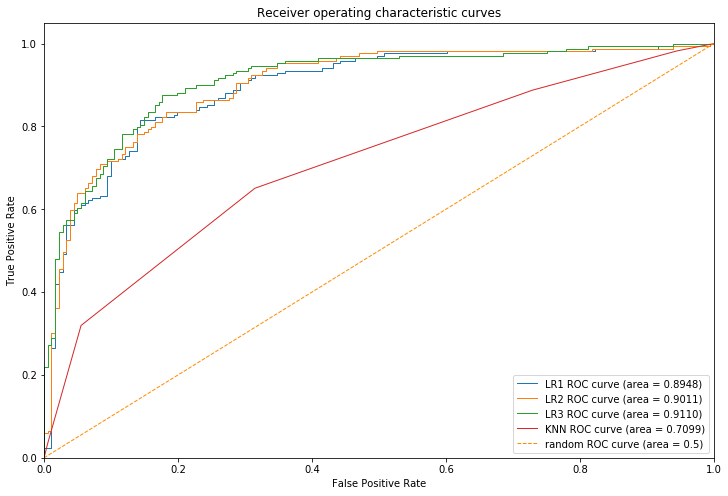

In [53]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

def generate_metrics(prediction):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test, prediction[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

lr_pred1 = lr1.predict_proba(X_test_tfidf1)
lr_pred2 = lr2.predict_proba(X_test_tfidf2)
lr_pred3 = lr3.predict_proba(X_test_tfidf3)
knn_pred = knn.predict_proba(X_test_tfidf3)

plt.figure(figsize=(12, 8))
lr1_fpr, lr1_tpr, lr1_roc_auc = generate_metrics(lr_pred1)
lr2_fpr, lr2_tpr, lr2_roc_auc = generate_metrics(lr_pred2)
lr3_fpr, lr3_tpr, lr3_roc_auc = generate_metrics(lr_pred3)
knn_fpr, knn_tpr, knn_roc_auc = generate_metrics(knn_pred)
plt.plot(lr1_fpr[1], lr1_tpr[1], lw=1, label='LR1 ROC curve (area = %0.4f)' % lr1_roc_auc[1])
plt.plot(lr2_fpr[1], lr2_tpr[1], lw=1, label='LR2 ROC curve (area = %0.4f)' % lr2_roc_auc[1])
plt.plot(lr3_fpr[1], lr3_tpr[1], lw=1, label='LR3 ROC curve (area = %0.4f)' % lr3_roc_auc[1])
plt.plot(knn_fpr[1], knn_tpr[1], lw=1, label='KNN ROC curve (area = %0.4f)' % knn_roc_auc[1])
plt.plot([0, 1], [0, 1], lw=1, color='darkorange', linestyle='--', label='random ROC curve (area = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curves')
plt.legend(loc='best')
plt.show()

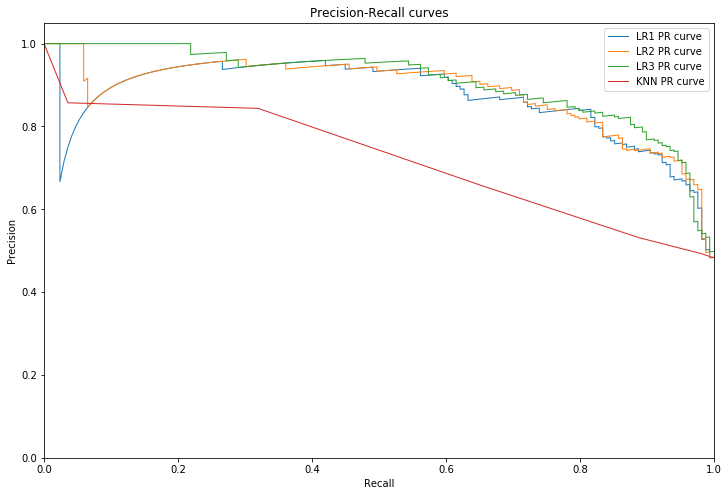

In [54]:
plt.figure(figsize=(12, 8))
precision1, recall1, _ = precision_recall_curve(y_test, lr_pred1[:, 1])
precision2, recall2, _ = precision_recall_curve(y_test, lr_pred2[:, 1])
precision3, recall3, _ = precision_recall_curve(y_test, lr_pred3[:, 1])
precision_knn, recall_knn, _ = precision_recall_curve(y_test, knn_pred[:, 1])

plt.plot(recall1, precision1, lw=1, label='LR1 PR curve')
plt.plot(recall2, precision2, lw=1, label='LR2 PR curve')
plt.plot(recall3, precision3, lw=1, label='LR3 PR curve')
plt.plot(recall_knn, precision_knn, lw=1, label='KNN PR curve')

plt.title('Precision-Recall curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='best')
plt.show()

### 6 Задания для самостоятельного решения

1) https://github.com/esokolov/ml-minor-hse/blob/master/colloquium-2017/colloquium_minor_problems_metrics.ipynb

2) При решении задачи бинарной классификации алгоритм на отложенной выборке верно предсказывает 75 из 100 объектов класса 0 и 100 из 400 объектов класса 1. Найдите долю правильных ответов, точность, полноту и F-меру данного классификатора.

3) Почему в некоторых задачах использовать точность и полноту лучше, чем долю правильных ответов?

4) Чем выше точность, тем меньше … . Чем выше полнота, тем меньше … .

* TP, TN

* TN, TP

* FP, FN

* FN, FP

5) PR-кривая ... проходит через точку (0, 0). PR-кривая ... проходит через точку (1, 1).

* всегда, всегда

* всегда, не всегда

* не всегда, всегда

* не всегда, не всегда

6) ROC-кривая ... проходит через точку (0, 0). ROC-кривая ... проходит через точку (1, 1).

* всегда, всегда

* всегда, не всегда

* не всегда, всегда

* не всегда, не всегда

7) Рассмотрим выборку из трех объектов, принадлежащих к классам 0, 1 и 1 соответственно. Оценка принадлежности классу 1 алгоритма классификации для первого объекта равна 0.2, для второго - 0.4, и для третьего - 0.9. Найдите площадь под PR-кривой и площадь под ROC-кривой для данного классификатора на данной выборке.

8) Рассмотрим следующий набор предложений:

* Сегодня магазин закрыт, так что я туда не пошел

* Я не пошел в магазин

* Я пошел в магазин - тебе что-то купить?

Какое из следующих слов будет обладать наибольшим TF-IDF в последнем предложении? Вычислите соответствующее ему значение TF-IDF.

* Я

* пошел

* магазин

* тебе

9) Возможно, вы сможете улучшить свой результат на данных о пассажирах Титаника, пользуясь свежими знаниями? :)

10) Какие из описанных метрик классификации не очень подходят для задач бинарной классификации с несбалансированными классами, а какие - наоборот? (google it - "дисбаланс классов" = "class imbalance")